# Fit using general zeta function

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
# from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$$ 
con
$$ series(n_v,p,z,a) = \sum_{i=0}^{n_v-1} \frac{z^i}{(i+a)^p}  $$ 

In [3]:
def serie_divergente(n: int,p: float, z: float=1, a: float=1):
    res = 0
    for i in np.arange(0,n,1):
        res = res + z**i/((i+a)**p)
    return res


def model_function(x: float,coefs):
    """x = 1/nv"""
    a1,a2 = coefs
    return a1*(1/serie_divergente(1/x,p,z=1,a=a2))


def get_extrapol_function(model_function, coefs):
    def extrapol_funct(x):
        return model_function(x, coefs)
    return extrapol_funct

In [4]:
def residuals_func(coefs,x,fi,fi_err=None,rescale_incert=100):
    """Calculate the residuals for the least squares minimization routine.
    
    This function returns a value with the difference between the expected value
    of the model, which we set to zero for all x and y, and the predictions of the
    model.
    Args:
        coefs: Tuple: Parameters to be adjusted of the model
        x: float: Independent variable
        fi: float: Experimental value to adjust, also call y_i
        fi_err: Error for the experimental value, also call y_err_i
    Returns:
        residuals: float: Difference of the model evaluation and expected value
    """
    # We want the model to be almost zero, i.e., that the coefficients and data
    # satisfy the conic equation.
    if fi_err is not None:
        residuals = (fi - model_function(
            x,
            coefs
        )) / (fi_err*rescale_incert)
        
        return residuals
    else:
        residuals = fi - model_function(
            x,
            coefs
        )
        
        return residuals


def get_residuals_func_sum_sqr(x_data,y_data,y_data_err=None,rescale_err=100):
    def residuals_func_sum_sqr(coefs):
        """Calculate the sum of the squared residuals."""
        result = 0
        num_el = len(x_data)
        for index in range(num_el):
            if y_data_err is not None:
                result = result + residuals_func(coefs,x_data[index],y_data[index],y_data_err[index],rescale_err)**2
            else:
                result = result + residuals_func(coefs,x_data[index],y_data[index])**2
        return result

    return residuals_func_sum_sqr

In [5]:
# get inv_temp
data_path = Path("../../data/regular/infinite-size").resolve()
file = 'regular_all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))
# get uncert inv_temp
file_err = 'regular_all_inv_Tc_uncertainty.csv'
df_all_tc_err = pd.read_csv(os.path.join(data_path,file_err))

In [6]:
df_all_tc

,1/nv,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.671622,0.680297,0.700150,0.717028,0.734866,0.751726,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.516743,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.438057,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.389057,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.354681,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.328996,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.308949,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.292798,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.279327,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.267970,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


## Read files

In [20]:
# with error
df_params = pd.DataFrame(index=["a1","a2","a1_err","a2_err"])
df_extrapol_val = pd.DataFrame(index=["infty","infty_err"])

------------------
p = 1.0
------------------
rescale_incert: 2946.4120552339014
      fun: 0.00035750693581413696
 hess_inv: array([[  3.24804696, -30.15317921],
       [-30.15317921, 287.29793619]])
      jac: array([-4.22518497e-07, -4.97457222e-08])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([0.47453971, 2.48412671])


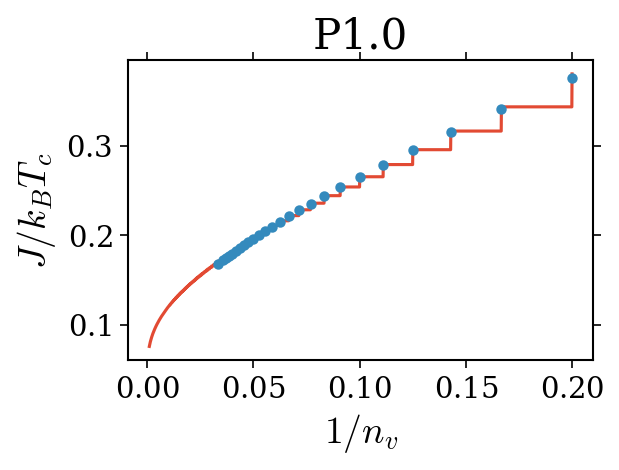

---------------------------------------------
coefs:[0.47453971 2.48412671]
---------------------------------------------
min:0.07636137695918649 at 0.001
fit at 1/nv=1: 1.1788167653303536


hess_inv: [  3.24804696 -30.15317921]
hess_inv: [-30.15317921 287.29793619]
Uncertainty: [0.034076374726725464, 0.3204855766359641]
------------------
p = 1.05
------------------
rescale_incert: 349224.2753609501
      fun: 0.00037795606685815496
 hess_inv: array([[  2.79897875, -24.63582717],
       [-24.63582717, 222.61989476]])
      jac: array([3.90095738e-06, 4.40639269e-07])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.46781646, 2.42913379])


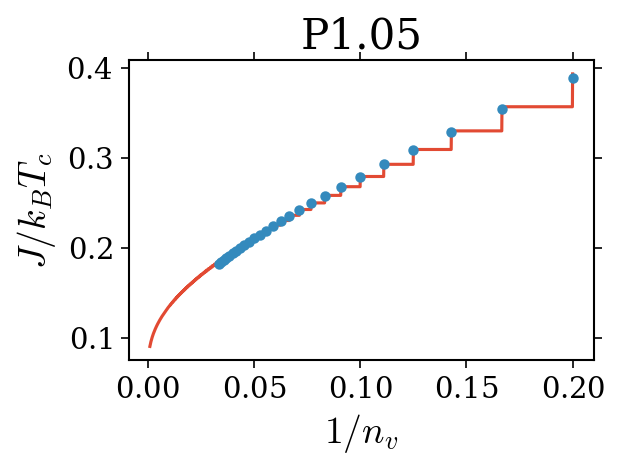

---------------------------------------------
coefs:[0.46781646 2.42913379]
---------------------------------------------
min:0.09022198706193722 at 0.001
fit at 1/nv=1: 1.187953663739303


hess_inv: [  2.79897875 -24.63582717]
hess_inv: [-24.63582717 222.61989476]
Uncertainty: [0.032525236352818766, 0.2900698878326839]
------------------
p = 1.1
------------------
rescale_incert: 3985.007096610753
      fun: 0.0003763181103730624
 hess_inv: array([[  2.97165946, -23.93869227],
       [-23.93869227, 197.11499316]])
      jac: array([1.15942385e-08, 3.78349796e-10])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.46551875, 2.34651251])


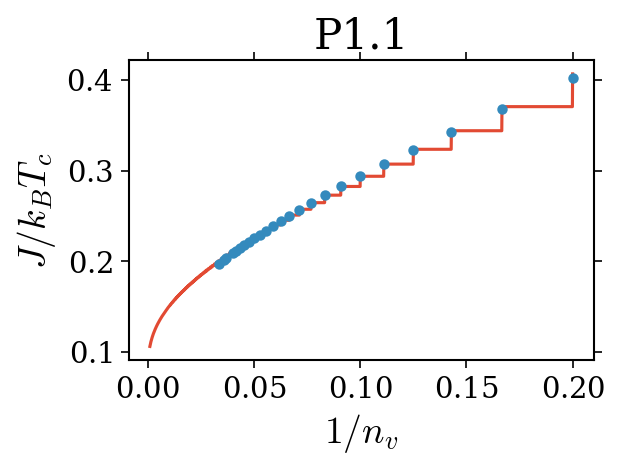

---------------------------------------------
coefs:[0.46551875 2.34651251]
---------------------------------------------
min:0.10623057200780366 at 0.001
fit at 1/nv=1: 1.189603785221935


hess_inv: [  2.97165946 -23.93869227]
hess_inv: [-23.93869227 197.11499316]
Uncertainty: [0.03344083243779554, 0.2723562772371672]
------------------
p = 1.2
------------------
rescale_incert: 3342.793084871539
      fun: 0.000388098809573894
 hess_inv: array([[  2.74511497, -19.39335551],
       [-19.39335551, 139.61563414]])
      jac: array([-7.30517786e-06, -1.11574627e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 13
     njev: 17
   status: 0
  success: True
        x: array([0.45605897, 2.24037231])


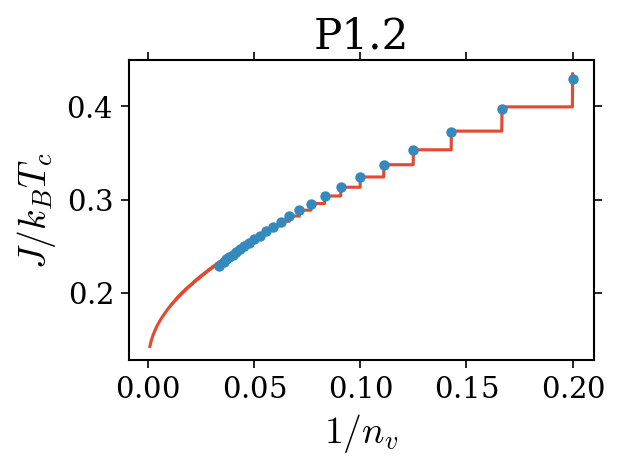

---------------------------------------------
coefs:[0.45605897 2.24037231]
---------------------------------------------
min:0.14224835315965043 at 0.001
fit at 1/nv=1: 1.2006190799833254


hess_inv: [  2.74511497 -19.39335551]
hess_inv: [-19.39335551 139.61563414]
Uncertainty: [0.03264009575420949, 0.2327759897600843]
------------------
p = 1.3
------------------
rescale_incert: 2828.109628802262
      fun: 0.0004091465991632693
 hess_inv: array([[  2.72401236, -16.73169688],
       [-16.73169688, 104.31192178]])
      jac: array([7.37643859e-07, 9.37070581e-08])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 14
     njev: 17
   status: 0
  success: True
        x: array([0.45204274, 2.1188708 ])


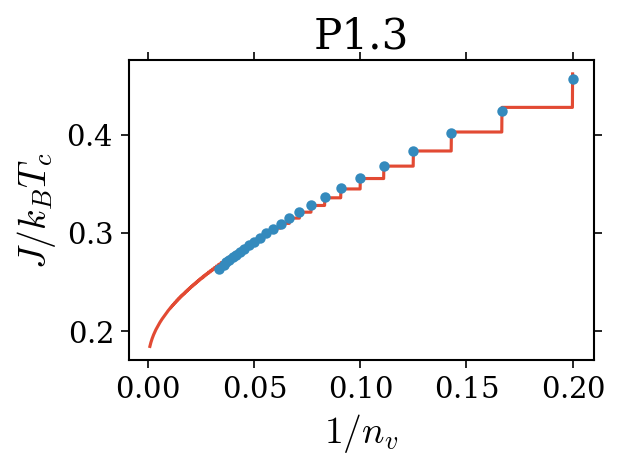

---------------------------------------------
coefs:[0.45204274 2.1188708 ]
---------------------------------------------
min:0.18460288802568148 at 0.001
fit at 1/nv=1: 1.1998178532895343


hess_inv: [  2.72401236 -16.73169688]
hess_inv: [-16.73169688 104.31192178]
Uncertainty: [0.03338443339106289, 0.20658864453100387]
------------------
p = 1.4
------------------
rescale_incert: 2414.8739761938814
      fun: 0.0003860039195421621
 hess_inv: array([[  2.94374801, -15.7110828 ],
       [-15.7110828 ,  84.93951412]])
      jac: array([-2.96459257e-06, -1.28794272e-06])
  message: 'Optimization terminated successfully.'
     nfev: 57
      nit: 14
     njev: 19
   status: 0
  success: True
        x: array([0.44673269, 2.03037357])


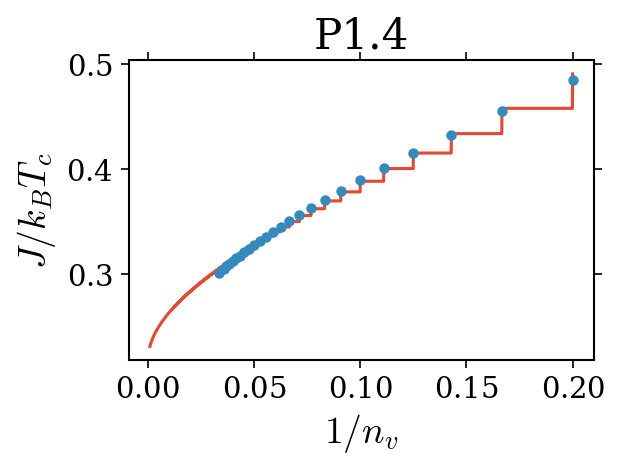

---------------------------------------------
coefs:[0.44673269 2.03037357]
---------------------------------------------
min:0.23125020816874378 at 0.001
fit at 1/nv=1: 1.2040764675627362


hess_inv: [  2.94374801 -15.7110828 ]
hess_inv: [-15.7110828   84.93951412]
Uncertainty: [0.0337090235655213, 0.1810717685785086]
------------------
p = 1.5
------------------
rescale_incert: 2077.210454371161
      fun: 0.00035970279701298696
 hess_inv: array([[  3.03871547, -14.2152784 ],
       [-14.2152784 ,  67.09543151]])
      jac: array([1.46343882e-06, 3.01886757e-07])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 17
     njev: 20
   status: 0
  success: True
        x: array([0.44751521, 1.92811434])


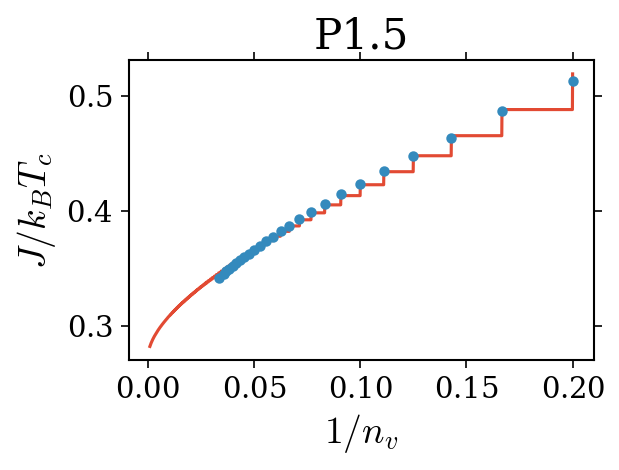

---------------------------------------------
coefs:[0.44751521 1.92811434]
---------------------------------------------
min:0.2819399975898202 at 0.001
fit at 1/nv=1: 1.1981383607509875


hess_inv: [  3.03871547 -14.2152784 ]
hess_inv: [-14.2152784   67.09543151]
Uncertainty: [0.033061071565843, 0.15535254868034673]
------------------
p = 1.6
------------------
rescale_incert: 1804.9875561417791
      fun: 0.0002953176046828655
 hess_inv: array([[  3.55838217, -14.20482102],
       [-14.20482102,  57.05616073]])
      jac: array([2.75795173e-08, 6.18092599e-09])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 19
     njev: 24
   status: 0
  success: True
        x: array([0.45311936, 1.82570379])


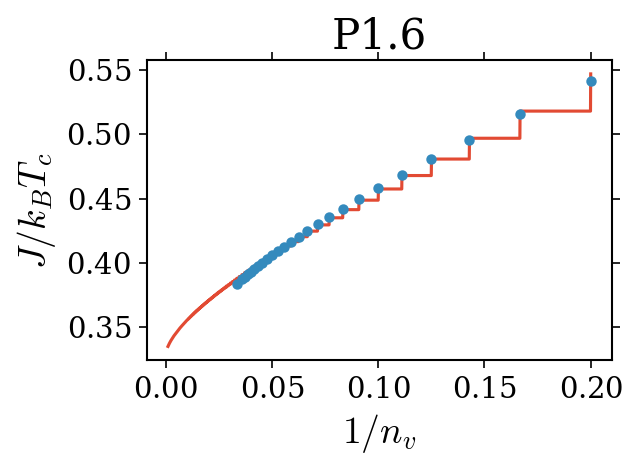

---------------------------------------------
coefs:[0.45311936 1.82570379]
---------------------------------------------
min:0.3349921747525958 at 0.001
fit at 1/nv=1: 1.1871377779222247


hess_inv: [  3.55838217 -14.20482102]
hess_inv: [-14.20482102  57.05616073]
Uncertainty: [0.03241686132680469, 0.12980635084375308]
------------------
p = 1.7
------------------
rescale_incert: 1579.4966158757784
      fun: 0.00022630298582704004
 hess_inv: array([[  4.52272828, -15.10860588],
       [-15.10860588,  50.68801295]])
      jac: array([-2.82735891e-06, -8.68019924e-07])
  message: 'Optimization terminated successfully.'
     nfev: 99
      nit: 21
     njev: 33
   status: 0
  success: True
        x: array([0.46545122, 1.72026914])


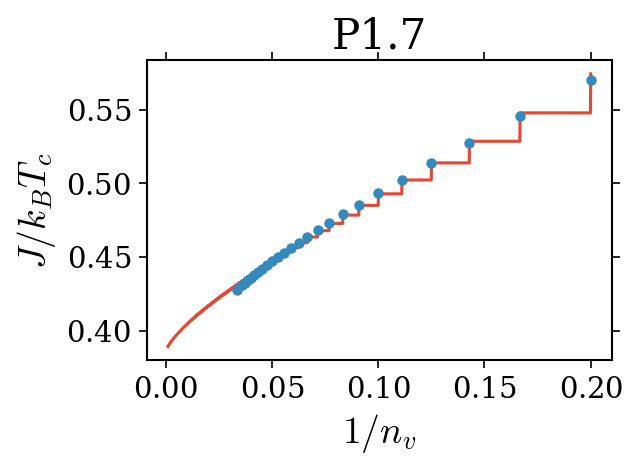

---------------------------------------------
coefs:[0.46545122 1.72026914]
---------------------------------------------
min:0.38921370614759476 at 0.001
fit at 1/nv=1: 1.1705448393099522


hess_inv: [  4.52272828 -15.10860588]
hess_inv: [-15.10860588  50.68801295]
Uncertainty: [0.03199229461170698, 0.10710204795844984]
------------------
p = 1.8
------------------
rescale_incert: 1393.1334722953932
      fun: 0.00014587978332118877
 hess_inv: array([[  6.47837873, -17.656603  ],
       [-17.656603  ,  48.26877678]])
      jac: array([7.89281148e-06, 2.77225263e-06])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 29
     njev: 36
   status: 0
  success: True
        x: array([0.48664751, 1.61135367])


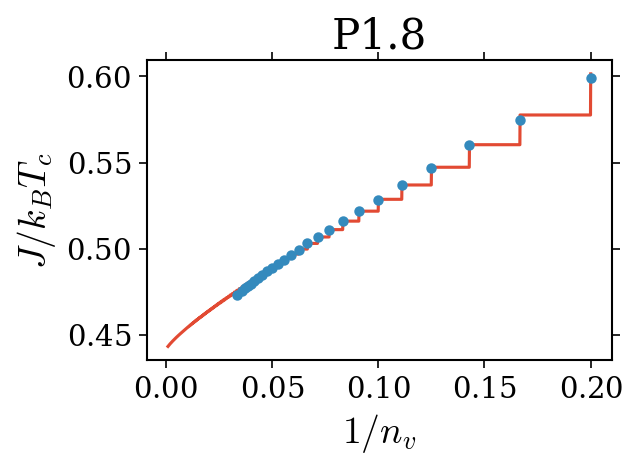

---------------------------------------------
coefs:[0.48664751 1.61135367]
---------------------------------------------
min:0.44340834730935486 at 0.001
fit at 1/nv=1: 1.1485716069865244


hess_inv: [  6.47837873 -17.656603  ]
hess_inv: [-17.656603    48.26877678]
Uncertainty: [0.030741901139816213, 0.08391328081802643]
------------------
p = 1.9
------------------
rescale_incert: 1241.1959449184753
      fun: 7.635710441904932e-05
 hess_inv: array([[ 10.24634642, -22.13100077],
       [-22.13100077,  47.88672807]])
      jac: array([-4.39333780e-06, -1.92031803e-06])
  message: 'Optimization terminated successfully.'
     nfev: 111
      nit: 27
     njev: 37
   status: 0
  success: True
        x: array([0.52164053, 1.49512081])


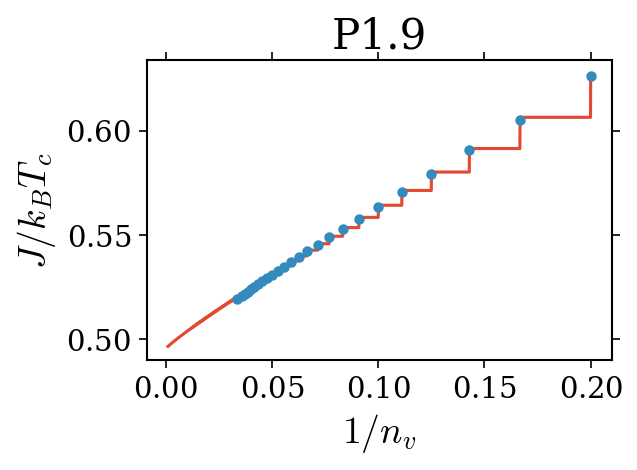

---------------------------------------------
coefs:[0.52164053 1.49512081]
---------------------------------------------
min:0.49665447662418166 at 0.001
fit at 1/nv=1: 1.1200986485932671


hess_inv: [ 10.24634642 -22.13100077]
hess_inv: [-22.13100077  47.88672807]
Uncertainty: [0.02797108049010739, 0.06046893331074129]
------------------
p = 2.0
------------------
rescale_incert: 1112.9486869985747
      fun: 4.301427397662067e-05
 hess_inv: array([[ 14.42489792, -23.85664631],
       [-23.85664631,  39.50644006]])
      jac: array([-7.09717688e-06, -5.48643993e-06])
  message: 'Optimization terminated successfully.'
     nfev: 108
      nit: 27
     njev: 36
   status: 0
  success: True
        x: array([0.57402576, 1.37680327])


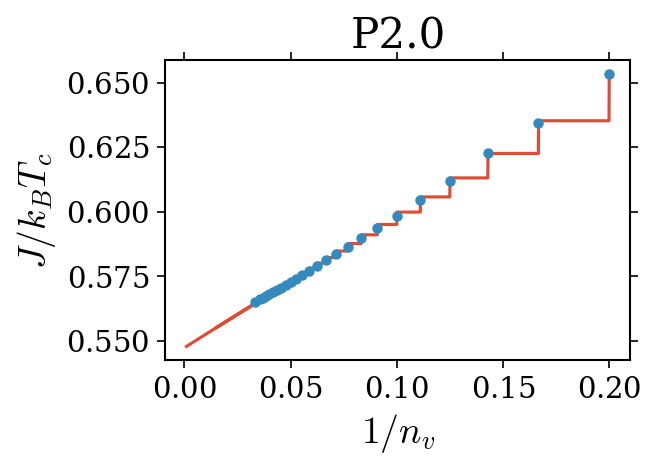

---------------------------------------------
coefs:[0.57402576 1.37680327]
---------------------------------------------
min:0.5478379960826724 at 0.001
fit at 1/nv=1: 1.0881159076180493


hess_inv: [ 14.42489792 -23.85664631]
hess_inv: [-23.85664631  39.50644006]
Uncertainty: [0.02490936593691556, 0.041223061948744116]


In [21]:
epsilon = 0.0001
tol = 2.220446049250313e-09 # tolerance by minimize 
chi_squared = False
min_nv = 5
if min_nv == 1:
    nv_ind = 0
else:
    nv_ind = min_nv-2
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
# COLUMNS = ["P1.05"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_{}plus_and_error_v30nv'.format(min_nv)
if chi_squared is True:
    file_name_base += "_chi-squared"
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    print("------------------")
    print("p = {}".format(p))
    print("------------------")
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]][nv_ind:]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    y_data_err = df_all_tc_err[COLUMN].dropna()[nv_ind:].values

    if min_nv == 1:
        # add value at nv=1
        x_data = np.concatenate([x_data,[1]])
        y_data = np.concatenate([y_data,[1.19968]])
        if COLUMN == 'P1.0':
            #add value at nv=infty
            x_data = np.insert(x_data,0,0)
            y_data = np.insert(y_data,0,0)
    
    # rescale
    rescale_incert = 1/y_data_err[3]
    print('rescale_incert: {}'.format(rescale_incert))
        
    # fit 
    if chi_squared is True:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err,rescale_incert)
    else:
        funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
#     funct_to_min = get_residuals_func_sum_sqr(x_data,y_data,y_data_err,rescale_incert)
#     funct_to_min = get_residuals_func_sum_sqr(x_data,y_data)
    best_fit_result = minimize(funct_to_min,
                               x0=(1,1.5),
#                                method = 'Nelder-Mead',
                               options={'maxiter':100},
#                                tol=tol
                              )
    print(best_fit_result)

    extrapol_funct = get_extrapol_function(model_function, best_fit_result.x)
    
    # define the point for graph
    x_extrapol = np.linspace(0.001, 1/(min_nv), 2048)
    y_extrapol = []
    for x_ext in x_extrapol:
        y_extrapol.append(extrapol_funct(x_ext))

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
#     ax.text(0.1, 0.2, r"$ \frac{J}{k_BT} = a_1 \left(\frac{1}{series(n_v,p,z=1,a=a_2)}\right)$",
#            fontsize=8)

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("---------------------------------------------")
    print("coefs:{}".format(best_fit_result.x))
    print("---------------------------------------------")
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))
    print("fit at 1/nv=1: {}".format(extrapol_funct(1)))
    print("\n")
    
    # For errors
    uncertainty = []
    tmp_i = np.zeros(len(best_fit_result.x))
    for i in range(len(best_fit_result.x)):
        tmp_i[i] = 1.0
        hess_inv = np.dot(best_fit_result.hess_inv,tmp_i)
#         hess_inv = np.dot(best_fit_result.final_simplex[0],tmp_i)
        print('hess_inv: {}'.format(hess_inv))
#         uncertainty.append(np.sqrt(max(1, abs(best_fit_result.fun)) * tol * hess_inv[i]))
        uncertainty.append(np.sqrt(best_fit_result.fun * hess_inv[i]))
#         uncertainty.append(np.sqrt(hess_inv[i]))
        tmp_i[i] = 0
    print('Uncertainty: {}'.format(uncertainty))
        
    df_params[COLUMN] = [*best_fit_result.x,*uncertainty]

## Extrapol values and errors

In [22]:
df_params

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,0.474540,0.467816,0.465519,0.456059,0.452043,0.446733,0.447515,0.453119,0.465451,0.486648,0.521641,0.574026
a2,2.484127,2.429134,2.346513,2.240372,2.118871,2.030374,1.928114,1.825704,1.720269,1.611354,1.495121,1.376803
a1_err,0.034076,0.032525,0.033441,0.032640,0.033384,0.033709,0.033061,0.032417,0.031992,0.030742,0.027971,0.024909
a2_err,0.320486,0.290070,0.272356,0.232776,0.206589,0.181072,0.155353,0.129806,0.107102,0.083913,0.060469,0.041223


In [23]:
def get_extrapol_err(coefs: object,p: float):
    params = [coefs["a1"],coefs["a2"]]
    params_err = [coefs["a1_err"],coefs["a2_err"]]
    all_eval_params = [[params[0]+params_err[0],params[1]+params_err[1]],
                       [params[0]+params_err[0],params[1]-params_err[1]],
                       [params[0]-params_err[0],params[1]+params_err[1]],
                       [params[0]-params_err[0],params[1]-params_err[1]],
                      ]
    all_err_extrapol = []
    for eval_par in all_eval_params:
        all_err_extrapol.append(abs(coefs['a1']*(1/zeta(p,coefs['a2'])) - eval_par[0]*(1/zeta(p,eval_par[1]))))
    return max(all_err_extrapol)

In [24]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.05","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9",
           "P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]=[df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2'])),get_extrapol_err(df_params[COLUMN],p)]

## Save params

In [25]:
print(np.arange(1,2.1,0.1))
print(1.036694*zeta(np.arange(1,2.1,0.1),1.005401))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
[        inf 10.96326581  5.78679131  4.06585347  3.20871592  2.69703051
  2.35801395  2.1176159   1.938811    1.80102955  1.69192972]


In [26]:
df_extrapol_val

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
infty,0.0,0.024186,0.04956,0.102219,0.157607,0.213803,0.271144,0.328581,0.385558,0.441409,0.495609,0.547316
infty_err,0.0,0.001860,0.00428,0.010026,0.017643,0.026235,0.034720,0.042625,0.049728,0.053584,0.051978,0.046973


In [27]:
df_params

,P1.0,P1.05,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
a1,0.474540,0.467816,0.465519,0.456059,0.452043,0.446733,0.447515,0.453119,0.465451,0.486648,0.521641,0.574026
a2,2.484127,2.429134,2.346513,2.240372,2.118871,2.030374,1.928114,1.825704,1.720269,1.611354,1.495121,1.376803
a1_err,0.034076,0.032525,0.033441,0.032640,0.033384,0.033709,0.033061,0.032417,0.031992,0.030742,0.027971,0.024909
a2_err,0.320486,0.290070,0.272356,0.232776,0.206589,0.181072,0.155353,0.129806,0.107102,0.083913,0.060469,0.041223


In [28]:
file_name_base

'inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_5plus_and_error_v30nv'

In [29]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

            P1.0     P1.05      P1.1      P1.2      P1.3      P1.4      P1.5  \
a1      0.474540  0.467816  0.465519  0.456059  0.452043  0.446733  0.447515   
a2      2.484127  2.429134  2.346513  2.240372  2.118871  2.030374  1.928114   
a1_err  0.034076  0.032525  0.033441  0.032640  0.033384  0.033709  0.033061   
a2_err  0.320486  0.290070  0.272356  0.232776  0.206589  0.181072  0.155353   

            P1.6      P1.7      P1.8      P1.9      P2.0  
a1      0.453119  0.465451  0.486648  0.521641  0.574026  
a2      1.825704  1.720269  1.611354  1.495121  1.376803  
a1_err  0.032417  0.031992  0.030742  0.027971  0.024909  
a2_err  0.129806  0.107102  0.083913  0.060469  0.041223  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\venv\data\regular\infinite-size\Extrapolation\inv_Tc_vs_inv_nv_extrapol_hurwitz_2_parms_with_nv_5plus_and_error_v30nv_params_curves.csv
           P1.0     P1.05     P1.1      P1.2      P1.3      P

## Plot extrapol values

c:\users\mhjguillermo\pycharmprojects\doctorado\ising\isingchat\venv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


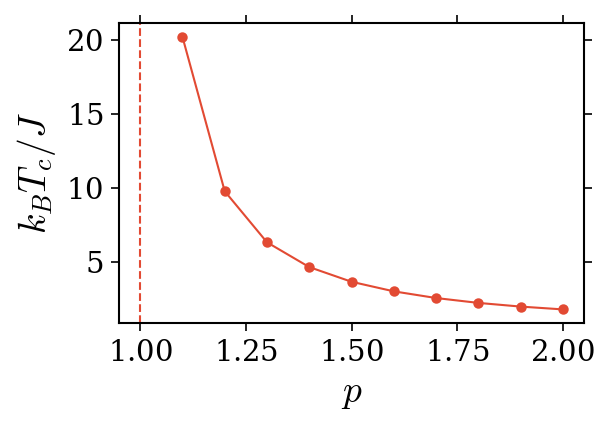

In [30]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values
y_data = np.delete(y_data,1)
# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

# print('Save graph {}'.format(file_extrapol_graph))
# pyplot.savefig(file_extrapol_graph)

pyplot.show()